In [1]:
import numpy as np
import pandas as pd
from pandas.api.types import CategoricalDtype
import sys
import warnings
%matplotlib inline
import seaborn as sns
import matplotlib.gridspec as gs
import matplotlib.pyplot as plt
import itertools
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import StratifiedKFold
from sklearn import preprocessing
from sklearn.model_selection import cross_val_score
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.neighbors import KNeighborsClassifier

In [2]:
np.random.seed(7)

In [3]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [4]:
cat = [1, 2, 3]
cat_type = CategoricalDtype(categories=cat, ordered=True)

In [5]:
def enforceTypesTitanic(df):
    try:
        df.Survived = df.Survived.astype("category")
    except:
        pass
    df.Pclass = df.Pclass.astype(cat_type)
    df.Sex = df.Sex.astype("category")
    df.Embarked = df.Embarked.astype("category")

In [6]:
enforceTypesTitanic(train)
enforceTypesTitanic(test)

In [7]:
def naSummary(df):
    return df.isnull().sum()

In [8]:
naSummary(train)

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [9]:
naSummary(test)

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

In [10]:
def distComparison(df1, df2):
    a = len(df1.columns)
    if a%2 != 0:
        a += 1
    
    n = np.floor(np.sqrt(a)).astype(np.int64)
    
    while a%n != 0:
        n -= 1
    
    m = (a/n).astype(np.int64)
    coords = list(itertools.product(list(range(m)), list(range(n))))
    
    numerics = df1.select_dtypes(include=[np.number]).columns
    cats = df1.select_dtypes(include=['category']).columns
    
    fig = plt.figure(figsize=(15, 15))
    axes = gs.GridSpec(m, n)
    axes.update(wspace=0.25, hspace=0.25)
    
    for i in range(len(numerics)):
        x, y = coords[i]
        ax = plt.subplot(axes[x, y])
        col = numerics[i]
        sns.kdeplot(df1[col].dropna(), ax=ax, label='df1').set(xlabel=col)
        sns.kdeplot(df2[col].dropna(), ax=ax, label='df2')
        
    for i in range(0, len(cats)):
        x, y = coords[len(numerics)+i]
        ax = plt.subplot(axes[x, y])
        col = cats[i]

        df1_temp = df1[col].value_counts()
        df2_temp = df2[col].value_counts()
        df1_temp = pd.DataFrame({col: df1_temp.index, 'value': df1_temp/len(df1), 'Set': np.repeat('df1', len(df1_temp))})
        df2_temp = pd.DataFrame({col: df2_temp.index, 'value': df2_temp/len(df2), 'Set': np.repeat('df2', len(df2_temp))})

        sns.barplot(x=col, y='value', hue='Set', data=pd.concat([df1_temp, df2_temp]), ax=ax).set(ylabel='Percentage')

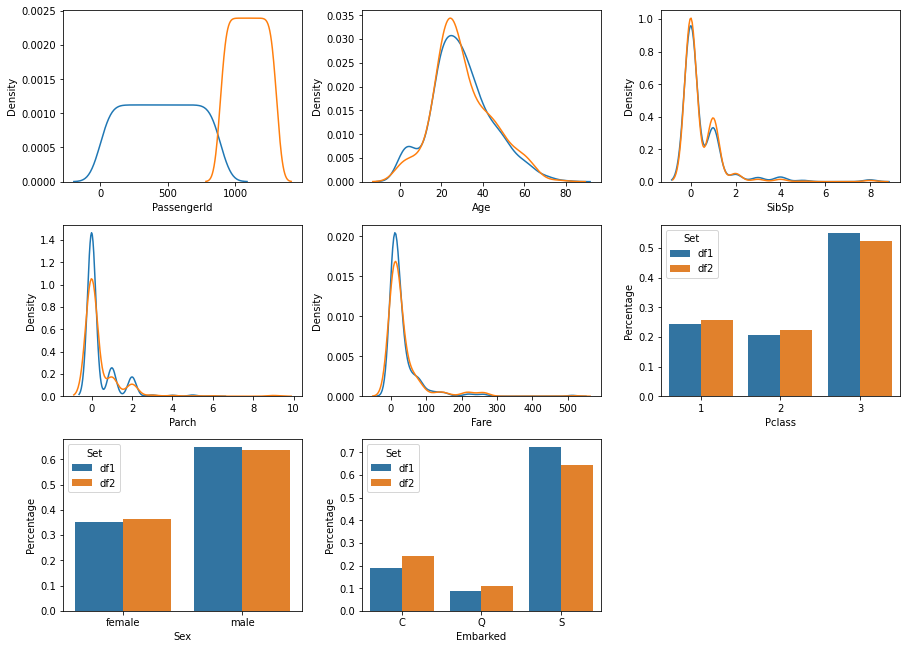

In [11]:
distComparison(train.drop('Survived', 1), test)

In [12]:
train.Embarked = train.Embarked.fillna('C')

train['CabinKnown'] = pd.Categorical((train.Cabin.isnull() == False))
test['CabinKnown'] = pd.Categorical((test.Cabin.isnull() == False))

test.Fare = test.Fare.fillna(8.05)

train = train.drop('Cabin', 1)
test = test.drop('Cabin', 1)

In [13]:
naSummary(train)

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Embarked         0
CabinKnown       0
dtype: int64

In [14]:
naSummary(test)

PassengerId     0
Pclass          0
Name            0
Sex             0
Age            86
SibSp           0
Parch           0
Ticket          0
Fare            0
Embarked        0
CabinKnown      0
dtype: int64

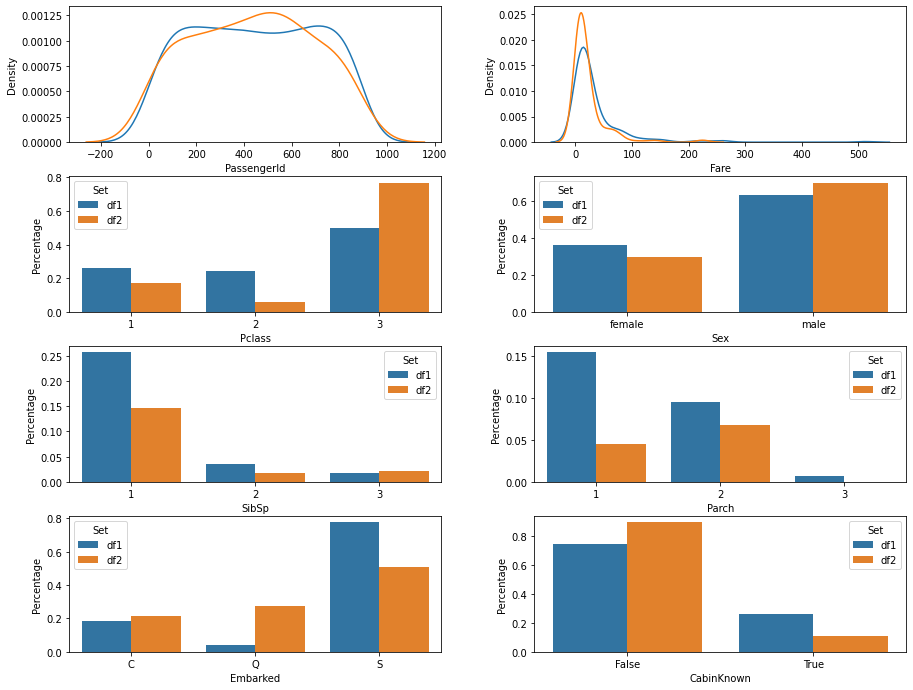

In [15]:
age_present = train.dropna().drop('Age', 1)
age_missing = train[train.isnull().any(axis=1)].drop('Age', 1)

age_present.Parch = age_present.Parch.astype(cat_type)
age_missing.Parch = age_missing.Parch.astype(cat_type)

age_present.SibSp = age_present.SibSp.astype(cat_type)
age_missing.SibSp = age_missing.SibSp.astype(cat_type)

distComparison(age_present.drop('Survived', 1), age_missing.drop('Survived', 1))

In [16]:
def prepForModel(df):
    new_df = df.copy()
    new_df.Pclass = new_df.Pclass.astype("int")
    new_df.Sex.cat.categories = [0, 1]
    new_df.Sex = new_df.Sex.astype("int")
    new_df.Embarked.cat.categories = [0, 1, 2]
    new_df.Embarked = new_df.Embarked.astype("int")
    new_df.CabinKnown.cat.categories = [0, 1]
    new_df.CabinKnown = new_df.CabinKnown.astype("int")
    return new_df

In [17]:
train_cl = prepForModel(train)
test_cl = prepForModel(test)

In [18]:
Xcol = ['Pclass', 'Sex', 'SibSp', 'Parch', 'Fare', 'Embarked', 'CabinKnown']
Ycol = 'Survived'

In [19]:
X = train_cl.loc[:, Xcol]
Y = train_cl.loc[:, Ycol]

In [20]:
Xbase = X
Ybase = Y

In [21]:
rf = RandomForestClassifier(n_estimators=1000, max_depth=None, min_samples_split=10)

In [22]:
baseline_err = cross_val_score(rf, X, Y, cv=10, n_jobs=-1).mean()
print("[BASELINE] Estimated RF Test Error (n = {}, 10-fold CV): {}".format(len(X), baseline_err))

[BASELINE] Estimated RF Test Error (n = 891, 10-fold CV): 0.8024843945068664


In [23]:
Xdel = train_cl.dropna().loc[:, Xcol + ['Age']]
Ydel = train_cl.dropna().loc[:, Ycol]

In [24]:
deletion_err = cross_val_score(rf, Xdel, Ydel, cv=10, n_jobs=-1).mean()
print("[DELETION] Estimated RF Test Error (n = {}, 10-fold CV): {}".format(len(Xdel), deletion_err))

[DELETION] Estimated RF Test Error (n = 714, 10-fold CV): 0.8167057902973396


In [25]:
train_cl = prepForModel(train)
train_cl.Age = train_cl.Age.fillna(train_cl.Age.mean(skipna=True))

In [26]:
Xcol = Xcol + ['Age']

In [27]:
Xmean = train_cl.loc[:, Xcol]
Ymean = train_cl.loc[:, Ycol]

In [28]:
mean_err = cross_val_score(rf, Xmean, Ymean, cv=10, n_jobs=-1).mean()
print("[MEAN] Estimated RF Test Error (n = {}, 10-fold CV): {}".format(len(Xmean), mean_err))

[MEAN] Estimated RF Test Error (n = 891, 10-fold CV): 0.8215730337078652


In [29]:
train_cl = prepForModel(train)
train_reg = train_cl.dropna()

In [30]:
Xrcol = ['Pclass', 'Sex', 'SibSp', 'Parch', 'Fare', 'Embarked', 'CabinKnown']
Yrcol = 'Age'

In [31]:
X_reg = train_reg.loc[:, Xrcol]
Y_reg = train_reg.loc[:, Yrcol]

In [32]:
age_lm = LinearRegression()
age_lm.fit(X_reg, Y_reg)
abs_residuals = np.absolute(Y_reg - age_lm.predict(X_reg))

In [33]:
nan_inds = train_cl.Age.isnull().to_numpy().nonzero()[0]
train_cl2 = train_cl.copy()

In [34]:
for i in nan_inds:
    train_cl.at[i, 'Age'] = age_lm.predict(train_cl.loc[i, Xrcol].values.reshape(1, -1))

In [35]:
Xreg = train_cl.loc[:, Xcol]
Yreg = train_cl.loc[:, Ycol]

In [36]:
reg_err = cross_val_score(rf, Xreg, Yreg, cv=10, n_jobs=-1).mean()
print("[DETERMINISTIC REGRESSION] Estimated RF Test Error (n = {}, 10-fold CV): {}".format(len(Xreg), reg_err))

[DETERMINISTIC REGRESSION] Estimated RF Test Error (n = 891, 10-fold CV): 0.828314606741573


In [37]:
for i in nan_inds:
    detreg = age_lm.predict(train_cl2.loc[i, Xrcol].values.reshape(1, -1))
    randreg = np.random.normal(detreg, np.random.choice(abs_residuals))
    train_cl2.at[i, 'Age'] = randreg

In [38]:
Xrandreg = train_cl2.loc[:, Xcol]
Yrandreg = train_cl2.loc[:, Ycol]

In [39]:
randreg_err = cross_val_score(rf, Xrandreg, Yrandreg, cv=10, n_jobs=-1).mean()
print("[RANDOM REGRESSION] Estimated RF Test Error (n = {}, 10-fold CV): {}".format(len(Xrandreg), randreg_err))

[RANDOM REGRESSION] Estimated RF Test Error (n = 891, 10-fold CV): 0.8226966292134831


In [40]:
train_cl = prepForModel(train)

In [41]:
X = train_cl.loc[:, Xcol]
Y = train_cl.loc[:, Ycol]

In [42]:
imp_mean = IterativeImputer(random_state=0)
Xmice = imp_mean.fit_transform(X, Y)
Ymice = Y

In [43]:
mice_err = cross_val_score(rf, Xmice, Y, cv=10, n_jobs=-1).mean()
print("[MICE] Estimated RF Test Error (n = {}, 10-fold CV): {}".format(len(Xmice), mice_err))

[MICE] Estimated RF Test Error (n = 891, 10-fold CV): 0.8283146067415729


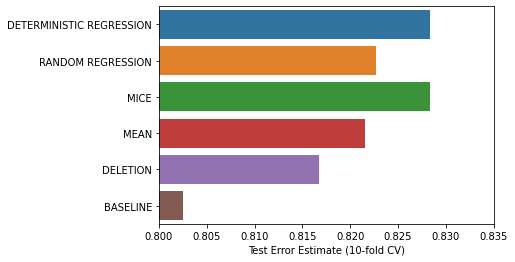

In [44]:
errs = {'DETERMINISTIC REGRESSION': reg_err, 
        'RANDOM REGRESSION': randreg_err,
        'MICE': mice_err,
        'MEAN': mean_err,
        'DELETION': deletion_err, 
        'BASELINE': baseline_err}

err_df = pd.DataFrame.from_dict(errs, orient='index')
err_df.index.name = 'Imputation Method'
err_df.reset_index(inplace=True)
err_df.columns = ['Imputation', 'Test Error Estimate (10-fold CV)']

ax = sns.barplot(x=err_df.columns[1], y=err_df.columns[0], order=list.sort(list(errs.values())), data=err_df)
ax.set_xlabel(err_df.columns[1])
ax.set_ylabel('')
_ = plt.xlim(0.8, 0.835)